In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import \
    roc_auc_score,\
    r2_score,\
    mean_absolute_error,\
    mean_squared_error,\
    accuracy_score,\
    classification_report,\
    confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
pd.set_option('display.max_columns',None)
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])
data['shipping_date']=pd.to_datetime(data['shipping date (DateOrders)'])

In [4]:
data['order_year'] = pd.DatetimeIndex(data['order_date']).year
data['order_month'] = pd.DatetimeIndex(data['order_date']).month
data['order_day'] = pd.DatetimeIndex(data['order_date']).day
data['shipping_year'] = pd.DatetimeIndex(data['shipping_date']).year
data['shipping_month'] = pd.DatetimeIndex(data['shipping_date']).month
data['shipping_day'] = pd.DatetimeIndex(data['shipping_date']).day

In [5]:
new_dataset_features = ['Type','Days for shipping (real)','Days for shipment (scheduled)','Late_delivery_risk','Benefit per order',
                        'Sales per customer','Latitude','Longitude','Shipping Mode','Order Status','Order Region',
                        'Order Country','Order City','Market','Delivery Status','order_day','order_month','order_year',
                        'shipping_day','shipping_month','shipping_year']
len(new_dataset_features)

21

In [6]:

new_data = data[new_dataset_features]
model_data = new_data
new_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Benefit per order,Sales per customer,Latitude,Longitude,Shipping Mode,Order Status,Order Region,Order Country,Order City,Market,Delivery Status,order_day,order_month,order_year,shipping_day,shipping_month,shipping_year
0,DEBIT,3,4,0,91.250000,314.640015,18.251453,-66.037056,Standard Class,COMPLETE,Southeast Asia,Indonesia,Bekasi,Pacific Asia,Advance shipping,31,1,2018,3,2,2018
1,TRANSFER,5,4,1,-249.089996,311.359985,18.279451,-66.037064,Standard Class,PENDING,South Asia,India,Bikaner,Pacific Asia,Late delivery,13,1,2018,18,1,2018
2,CASH,4,4,0,-247.779999,309.720001,37.292233,-121.881279,Standard Class,CLOSED,South Asia,India,Bikaner,Pacific Asia,Shipping on time,13,1,2018,17,1,2018
3,DEBIT,3,4,0,22.860001,304.809998,34.125946,-118.291016,Standard Class,COMPLETE,Oceania,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,16,1,2018
4,PAYMENT,2,4,0,134.210007,298.250000,18.253769,-66.037048,Standard Class,PENDING_PAYMENT,Oceania,Australia,Townsville,Pacific Asia,Advance shipping,13,1,2018,15,1,2018


In [7]:
model_data = pd.get_dummies(model_data)
model_data.shape

(180519, 3823)

In [8]:
x = model_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)
y = model_data[['Days for shipping (real)','Days for shipment (scheduled)']]
x.shape,y.shape

((180519, 3821), (180519, 2))

In [9]:

x_train,x_test,y_train,y_test = model_selection.train_test_split(x,y,test_size=0.20)

In [10]:
model=DecisionTreeRegressor()
model.fit(x_train,y_train)
pred=model.predict(x_test)


In [11]:
def metrics(y_test,pred):
    a =r2_score(y_test,pred)
    b =mean_squared_error(y_test,pred)
    c =mean_absolute_error(y_test,pred)
    print('The r-squared score of the model is ',a)
    print('The mean squared error is',b)
    print('The mean accuracy score is',c)

In [12]:
metrics(y_test,pred)

The r-squared score of the model is  0.9905842250862767
The mean squared error is 0.02467870596055839
The mean accuracy score is 0.0216042543762464


In [13]:
Prediction = pd.DataFrame(pred)
prediction = Prediction.rename(columns={0:'Fastest_shipment',1:'Avg_shipment'})
prediction.head()

,Fastest_shipment,Avg_shipment
0,6.0,4.0
1,5.0,4.0
2,5.0,4.0
3,3.0,4.0
4,2.0,1.0


In [14]:
prediction['risk'] = np.where(prediction['Avg_shipment'] >= prediction['Fastest_shipment'],0,1)

In [15]:
prediction.head()

,Fastest_shipment,Avg_shipment,risk
0,6.0,4.0,1
1,5.0,4.0,1
2,5.0,4.0,1
3,3.0,4.0,0
4,2.0,1.0,1


In [16]:
l = prediction['risk']
m = x_test['Late_delivery_risk']
l.shape,m.shape

((36104,), (36104,))

In [17]:
def evaluation_risk_factor(l,m):
  print('1) The accuracy of the risk predictor model is :',accuracy_score(l,m))
  print('2) The AUROC score is :',roc_auc_score(l,m))
  print('3) Some of the key classification metrics are :')
  print(classification_report(l,m))
  ax=plt.subplot()
  sns.heatmap(confusion_matrix(l,m),annot=True,ax=ax);
  ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels')
  ax.set_title('Confusion matrix for Risk Delivery classfication');

1) The accuracy of the risk predictor model is : 0.9754320850875249
2) The AUROC score is : 0.9783995714007403
3) Some of the key classification metrics are :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15572
           1       1.00      0.96      0.98     20532

    accuracy                           0.98     36104
   macro avg       0.97      0.98      0.98     36104
weighted avg       0.98      0.98      0.98     36104



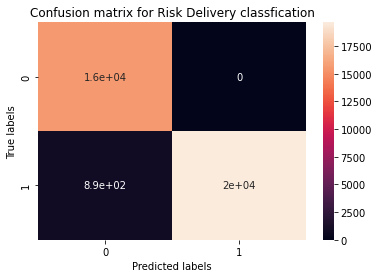

In [18]:
evaluation_risk_factor(l,m)

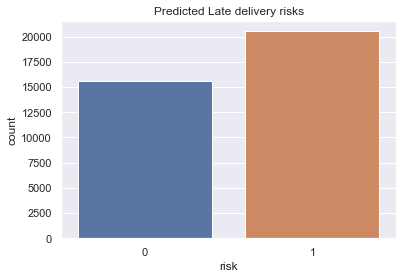

In [19]:
sns.set(style="darkgrid")
ax=sns.countplot(x="risk",data=prediction).set_title('Predicted Late delivery risks')

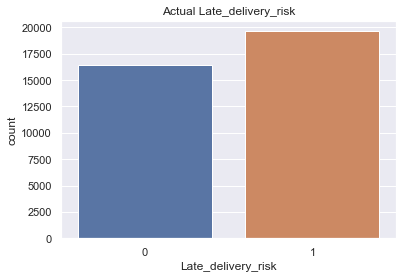

In [20]:
bx=sns.countplot(x='Late_delivery_risk',data=x_test).set_title('Actual Late_delivery_risk')